## Biodiversity of Endangered Species in National Parks

# Biodiversity in National Parks

## Introduction:
#### Dataset: 

Data on biodiversity of endangered species in National Parks has been provided by Codecademy.com as part of a portfolio project prompt.

The brief on the project states that the data is from the National Parks Service and covers observations of different species of various conservation levels at several US National parks. It states that we will investigate to find any patterns or themes to the types of species that become endangered. During this project I have transformed and loaded the data, investigated patterns and themes, and created representative visuals.

The initial dataset included two csv's, 'observations.csv' and 'species_info.csv'. Observations.csv contains 23296 rows of data on the species observed within four National Parks, with a count of observations, park where it was observed and scientific name of the species. The species_info.csv contains columns for scientific name, common names, and conservation status and has data for 5824 species. In data_cleaning_biodiversity.ipynb I removed duplicates, resolved missing data, and merged the two csv into one, biodiversity_data.csv for analysis.

The dataset includes scientific_name, common_names, the observation count, and three categorical variables. The categorical variables:
| Column Name | N-Unique | Unique Values |
| --- | ----------- | --------- |
| park_name | 4 | 'Bryce', 'Great Smokey Mountain', 'Yellowstone', 'Yosemite' | 
| conservation_status | 5 | 'Least Concern', 'Species of Concern', 'Threatened', 'Endangered', 'In Recovery' |
| category | 7 | 'Vascular Plant', 'Nonvascular Plant', 'Amphibian', 'Bird', 'Fish', 'Reptile', 'Mammal' |

Observations has the following spread:
| Measure | Observations |
| --- | ---|
| count | 22164 |
| mean | 149.5 |
| std | 81.2 |
| min | 9 |
| 25% | 88 |
| 50%  | 129 |
| 75% | 217 |
| max | 805 |

Additionally, new bionomial column 'protection_listing' was added based on the 'conservation_status' variable where 0 is 'Least Concern', and all other values are 1, ('Species of Concern', 'Threatened', 'Endangered', 'In Recovery'). It was added to separated those species with a conservation status from those without more quickly.

#### Analysis: 

Data was visualized to illuminate the number of observations that are predominated by species without a conservation status (ie 'Species of Least Concern') and within those observations by species in the category of plants ('Vascular Plants' and 'Nonvascular Plants').

Based on those visualizations there appeared to be differences between the different species categories with regard to protection listing,  and between the different parks with regard to observations. This analysis addresses three primary questions: Is there a correlation between species category and protection listed conservation statuses? Is there a correlation between National Park and observations? And, if so, is there an interaction between those two influences? 

Since the inital visualizations show a very large populations of the data reflects plants and species without a conservation protection status, the analysis breaks down the data set into subsets as well as addressing the dataset as a whole. The correlation between species category and protection listing was investigated for both the data set as a whole and in subsets of plants, animals, and animals with a protection listing vs a specific protection status. For each subset the analysis includes a calculation of the chi2 statistic and it's associated p-value, and for species with a statistically significant chi2 statistic, the Cramér's V to measure the strength of the correllation.

The second part of the analysis addresses the question of correlation between national park and observations. The observation counts were relatively normal for each park, as seen in figure 'park_observation_normalcy', so this dataset is a viable candidate for ANOVA. The ANOVA table was followed by a Tukey HSD to address the mean differences between each pair of parks and to tease out any differences that might not be statistically significant.

The final section of analysis focuses on the subset of animals with a protection listing. It asked the question is there an interaction between National Park and species category in terms of correlation with observations. Using a two-way ANOVA the analysis determined the strength of the individual variables on the observation means and their interaction with regard to the mean. 

#### Conclusions: 
Since conservation status is based on the population of a species alive in the wild, observations and conservation status are proxy measures and a correlation in one would indicate a correlation in the other.  

Species category across the dataset was moderately correlated with protection listing. While plant species had no correlation with protection listing, animal species showed a very weak, but statisically significant correlation. The weak relationship between animal species and protection listing suggested that a more nuanced analysis might show a more robust influence, so covariance analysis was performed on the subset of protection listed animals, comparing their conservation status with species category.  The Chi2 statistic and p-value indicated a statistically significant correlation, so Cramer's V was performed, showing a moderate relationship between species category and conservation status. 

The ANOVA for the ordinary least squares model of National Park and observations showed a statistically significant,  strong correlation to the mean observations across the dataset. Following up on the ANOVA, analysis with Tukey HSD was used to find the pairwise relationship of the means between each of the National Parks. All pairwise relationships were statistically significant. 

Finally, the interaction of species category and National Park were modeled vs observations for the subset of animals with protection listing. The strongest correlation was found between National Park and observations, with a strong, statistically significant difference of the means. Species Category was also correlated to observational means with a more moderate, but still statistically significant relationship. However, the variables are independent as the interaction between National Park and Species Category did not have a statistically significant relationship. 

In [101]:
#import py libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as ticker
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
from scipy.stats import chi2_contingency
#set options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})

In [102]:
biodiv = pd.read_csv("biodiversity_data.csv")
print(biodiv.describe())

       observations
count       22164.0
mean          149.5
std            81.2
min             9.0
25%            88.0
50%           129.0
75%           217.0
max           805.0


In [103]:
#the protection listing of a species can be thought of as an binomial variable where species of Least Concern: 0 and protection listed classes: 1. 
protected_class = {'Least Concern': 0, 'Species of Concern': 1, 'In Recovery': 1, 'Threatened':1, 'Endangered':1}
biodiv['protection_listing'] = biodiv['conservation_status'].apply(lambda x: protected_class.get(x))
print(biodiv.describe(include= 'all'))

       scientific_name park_name  observations        category conservation_status        common_names  protection_listing
count            22164     22164       22164.0           22164               22164               22164             22164.0
unique            5541         4           NaN               7                   5                5236                 NaN
top      Abies bifolia     Bryce           NaN  Vascular Plant       Least Concern  Brachythecium Moss                 NaN
freq                 4      5541           NaN           17048               21448                  28                 NaN
mean               NaN       NaN         149.5             NaN                 NaN                 NaN                 0.0
std                NaN       NaN          81.2             NaN                 NaN                 NaN                 0.2
min                NaN       NaN           9.0             NaN                 NaN                 NaN                 0.0
25%             

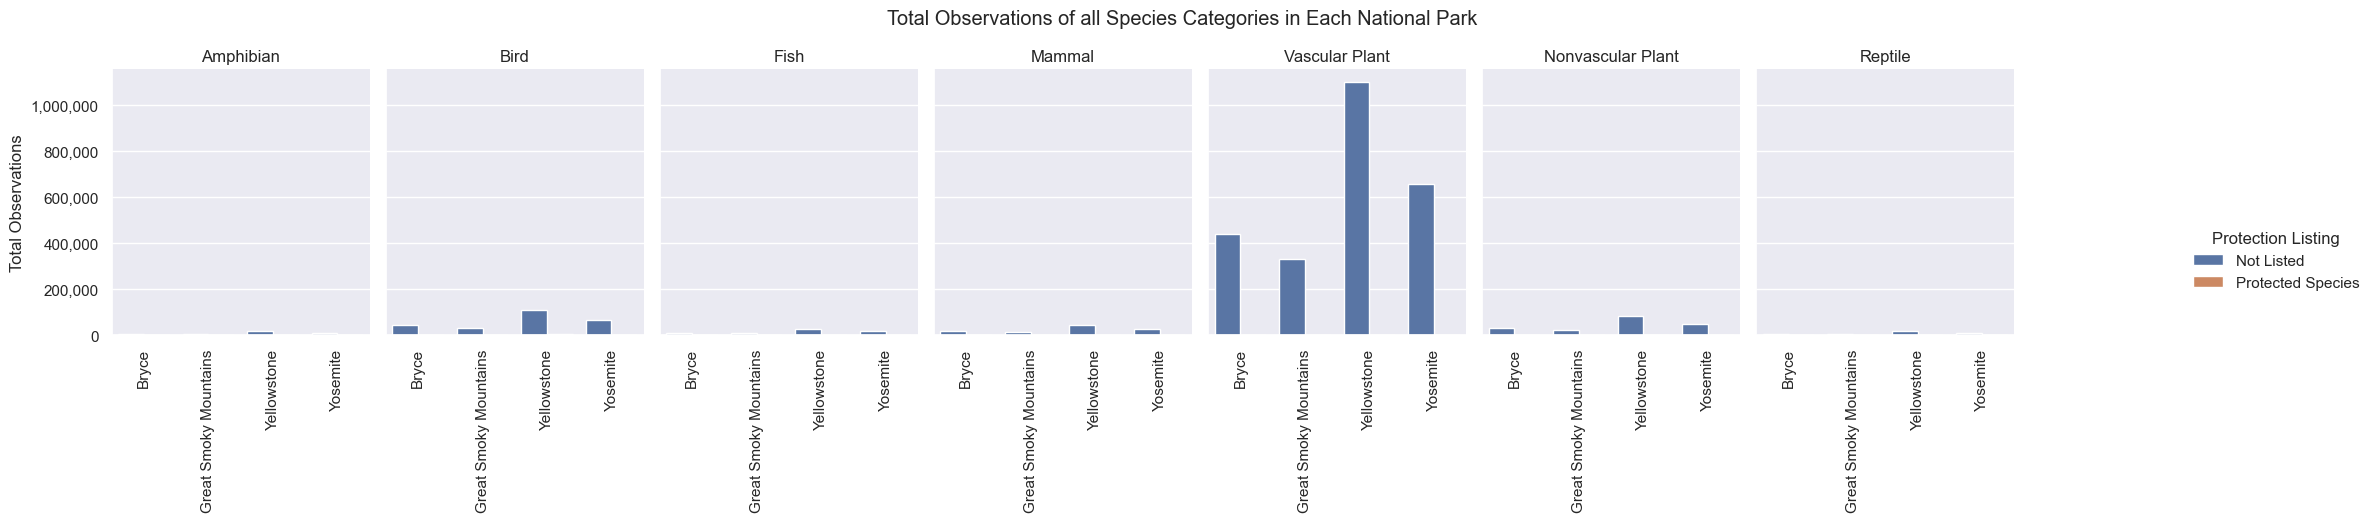

In [104]:
# create a visual of the data spread
biodiv_grouped = biodiv.groupby(['conservation_status', 'protection_listing', 'category', 'park_name'], as_index=False)["observations"].sum()

a=sns.catplot(
    data = biodiv_grouped,
    x='park_name',
    y='observations',
    col = 'category',
    hue= 'protection_listing',
    kind = 'bar',
    errorbar= None,
    height = 4,
    aspect = .8,
    #sharey= 'none'
    legend_out= True
)
a.set_xticklabels(rotation = 90)
a.set_titles("{col_name}")
a.figure.subplots_adjust(top=.86)
a.figure.suptitle('Total Observations of all Species Categories in Each National Park')
a.set_axis_labels('', 'Total Observations')
for ax in a.axes.flat:
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
legend = a._legend
legend.set_title('Protection Listing')
for t, l in zip(legend.texts,('Not Listed', 'Protected Species')):
    t.set_text(l)
a.figure.subplots_adjust(top=0.83
                      ,right=0.85)
plt.savefig("png_biodiv_total_observations.png")
plt.show()
plt.close('all')
#Plants and Species of Least Concern are hiding the visibility of vulnerable species. 


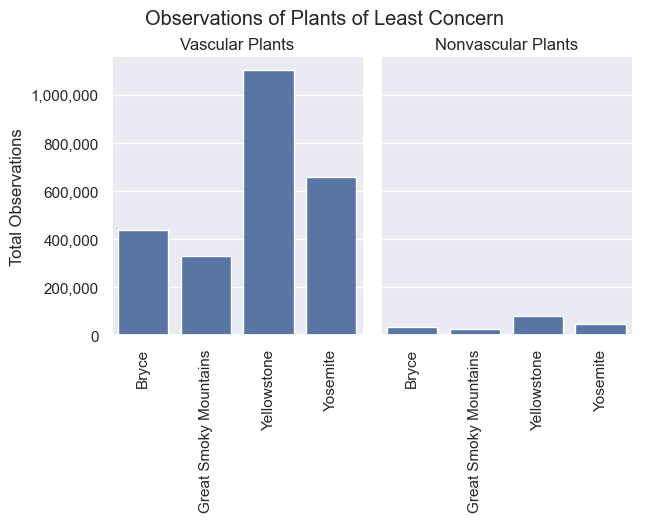

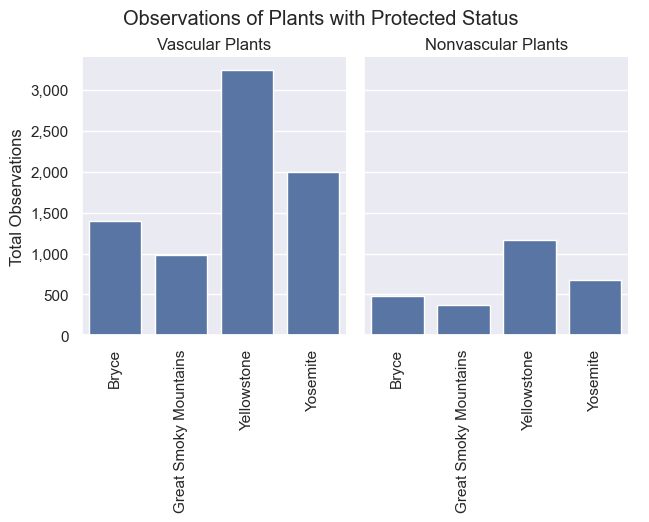

In [105]:
#For greater visibility into the protection status of relative groups of species and plants we can split into two dataframes, one for plants and one for animals.
#plants
biodiv_plants = biodiv[biodiv['category'].str.contains('Plant')].reset_index(drop=True)
biodiv_plants_gp_status= biodiv_plants.groupby(['conservation_status', 'protection_listing', 'category', 'park_name'], as_index=False)["observations"].sum()

g=sns.catplot(
    data = biodiv_plants_gp_status[biodiv_plants_gp_status['protection_listing']==0],
    x='park_name',
    y='observations',
    col = 'category',
    col_order = ['Vascular Plant', 'Nonvascular Plant'],
    kind = 'bar',
    errorbar= None,
    height = 4,
    aspect = .8,
    #sharey= 'none'
)
g.set_xticklabels(rotation = 90)
g.set_titles("{col_name}s")
g.figure.subplots_adjust(top=.86)
g.figure.suptitle('Observations of Plants of Least Concern')
g.set_axis_labels('', 'Total Observations')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("png_biodiv_total_obs_plants_0.png")
plt.show()
plt.close('all')
h=sns.catplot(
    data = biodiv_plants_gp_status[biodiv_plants_gp_status['protection_listing']==1],
    x='park_name',
    y='observations',
    col = 'category',
    col_order = ['Vascular Plant', 'Nonvascular Plant'],
    kind = 'bar',
    errorbar= None,
    height = 4,
    aspect = 0.8,
)
h.set_xticklabels(rotation = 90)
h.set_titles("{col_name}s")
h.figure.subplots_adjust(top=.86)
h.figure.suptitle('Observations of Plants with Protected Status')
h.set_axis_labels('', 'Total Observations')
for ax in h.axes.flat:
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("png_biodiv_total_obs_plants_1.png")
plt.show()
plt.close('all')

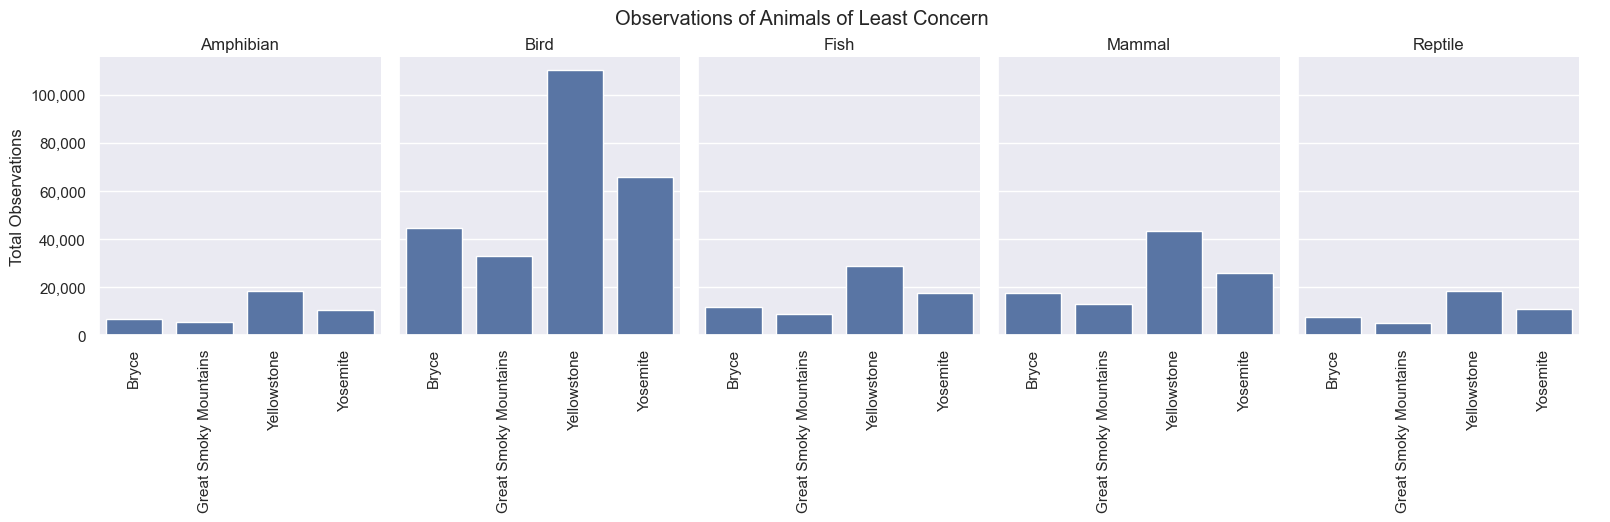

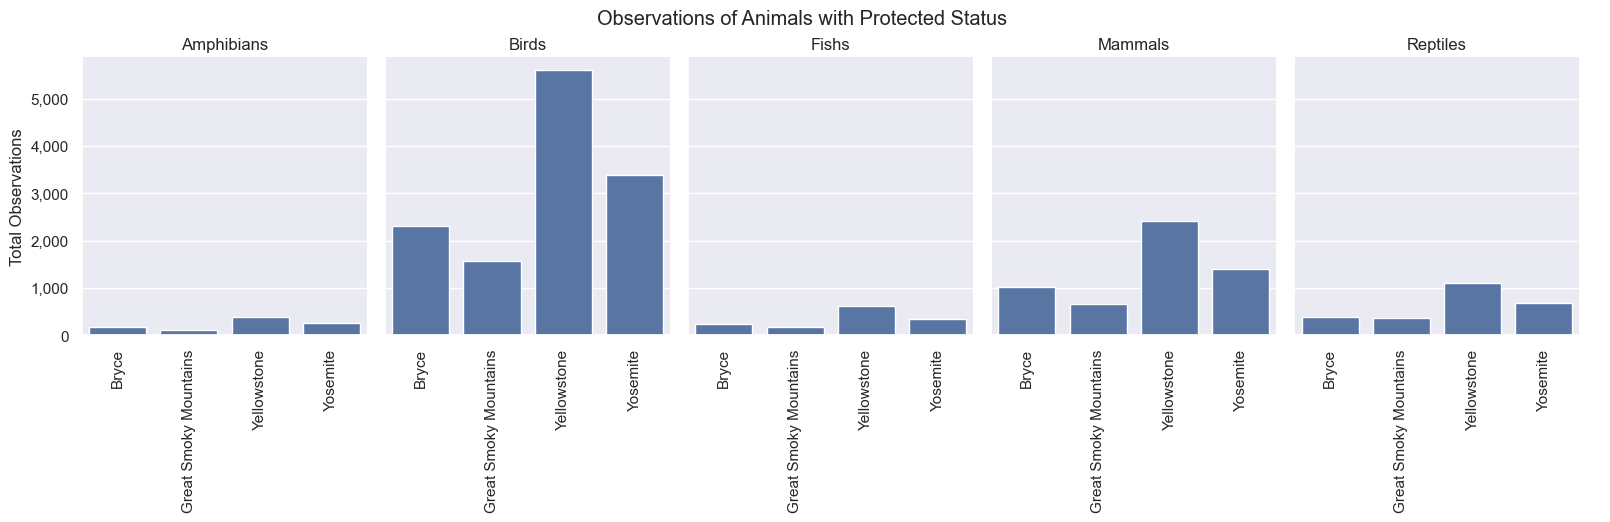

In [106]:
#For greater visibility into the protection status of relative groups of species and animals we can split into two dataframes, one for animals and one for animals.
#animals
biodiv_animals = biodiv[biodiv['category'].str.contains('Plant')==False].reset_index(drop=True)
biodiv_animals_gp_status= biodiv_animals.groupby(['conservation_status', 'protection_listing', 'category', 'park_name'], as_index=False)["observations"].sum()
category_order = list(biodiv_animals_gp_status.category.unique())
g=sns.catplot(
    data = biodiv_animals_gp_status[biodiv_animals_gp_status['protection_listing']==0],
    x='park_name',
    y='observations',
    col = 'category',
    #col_order = category_order,
    kind = 'bar',
    errorbar= None,
    height = 4,
    aspect = .8,
)
g.set_axis_labels('', 'Total Observations')
g.set_xticklabels(rotation = 90)
g.set_titles("{col_name}")
g.figure.subplots_adjust(top=.86)
g.figure.suptitle('Observations of Animals of Least Concern')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("png_biodiv_total_obs_animals_0.png")
plt.show()
plt.close('all')
h=sns.catplot(
    data = biodiv_animals_gp_status[biodiv_animals_gp_status['protection_listing']==1],
    x='park_name',
    y='observations',
    col = 'category',
    #col_order = category_order,
    kind = 'bar',
    errorbar= None,
    height = 4,
    aspect = 0.8
)

h.set_axis_labels('', 'Total Observations')
h.set_xticklabels(rotation = 90)
h.set_titles("{col_name}s")
h.figure.subplots_adjust(top=.86)
h.figure.suptitle('Observations of Animals with Protected Status')
for ax in h.axes.flat:
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("png_biodiv_total_obs_animals_1.png")
plt.show()
plt.close('all')

## Analysis:

### Is species category correlated with conservation status?
#### Method:
    - Group by species (scientific name) to meet independence of observation needed for Chi2
    - Create Contingency Tables for protection listing vs category across full dataset
    - Utilize stats.chi2_contingency to find Chi2 and p-value to ascertain correlation between variables.
    - Calculated Cramér's V to establish strength of corellation.
#### Analysis:
**All species**

The chi2 statistic, p-value, and Cramér's V for protection listing vs category for all species are displayed in the table below. The high Chi2 statistic and low p-value indicate a statistically significant correlation. The correlation is only of moderate strength as seen by the Cramér's V of 0.277.

| Chi2 | P-Value | Cramér's V |
| --- | --- | --- |
| 426.6 | 5.14 e-89 | 0.277 |

**Plant species**

There was no correlation between plant species and protection listing. 

| Chi2 | P-Value | Cramér's V |
| --- | --- | --- |
| 0.19| 0.66 | n/a |

**Animal species**

There was a slight correlation between animal category and protection listing, but based on the Cramér's V, the association was so weak that was not significant. 

| Chi2 | P-Value | Cramér's V |
| --- | --- | --- |
|10.5| 0.03 | 0.10 |

**Protected Animal category vs Conservation Status**

There was a moderate corelation between animal category and conservation status for animals with a protection listing. With a Chi2 over 40 and a p-val well below the threshold, it is a statistically significant association. 
| Chi2 | P-Value | Cramér's V |
| --- | --- | --- |
|40.91| 5.08 e-05 | 0.33 |

#### Analysis Summary:
There is a statistically significant, moderate correlation between species category and protection status across the full dataset, and a moderate statistically significant correlation between Animal category and conservation status for animals with a protected status.

In [107]:
#Calculated the contingency table and Chi-Square Statistic for Protection Status by Category
biodiv_species = biodiv.groupby(['scientific_name', 'category', 'conservation_status', 'protection_listing'], as_index=False)['observations'].sum()
status_category_contingency = pd.crosstab(biodiv_species['protection_listing'],biodiv_species['category'])
print(f"Contingency table for Protected Status vs Category:\n{status_category_contingency}")
chi2, pval, dof, expected =chi2_contingency(status_category_contingency)
print(f"Chi-square Statistic - for plant and animal categories: {chi2}")
print(f"P-value - for plant and animal categories: {pval}")
print(f"Degrees of Freedom - for plant and animal categories: {dof}")
#Calculate Cramér's V 
n = np.sum(status_category_contingency.sum())
r,c = status_category_contingency.shape
cramers_v = np.sqrt(chi2/(n*(min(r, c)-1)))
print(f"Cramér's V: {cramers_v}")

Contingency table for Protected Status vs Category:
category            Amphibian  Bird  Fish  Mammal  Nonvascular Plant  Reptile  Vascular Plant
protection_listing                                                                           
0                          72   413   114     146                328       73            4216
1                           7    75    11      30                  5        5              46
Chi-square Statistic - for plant and animal categories: 426.667296905628
P-value - for plant and animal categories: 5.146759135429976e-89
Degrees of Freedom - for plant and animal categories: 6
Cramér's V: 0.27749208693544747


In [108]:
biodiv_plant_species = biodiv_species[biodiv_species['category'].isin(['Nonvascular Plant', 'Vascular Plant'])]
biodiv_animal_species = biodiv_species[biodiv_species['category'].isin(['Bird', 'Amphibian', 'Reptile', 'Mammal', 'Fish'])]

In [109]:
plant_status_category_contingency = pd.crosstab(biodiv_plant_species['protection_listing'],biodiv_plant_species['category'])
print(f"Contingency table for Conservation Status vs Category - for Plants:\n{plant_status_category_contingency}")
chi2, pval, dof, expected = stats.chi2_contingency(plant_status_category_contingency)
print(f"Chi-square Statistic - for Plants: {chi2}")
print(f"P-value - for Plants: {pval}")
print(f"Degrees of Freedom - for Plants: {dof}")

Contingency table for Conservation Status vs Category - for Plants:
category            Nonvascular Plant  Vascular Plant
protection_listing                                   
0                                 328            4216
1                                   5              46
Chi-square Statistic - for Plants: 0.19069121233812064
P-value - for Plants: 0.6623419491381985
Degrees of Freedom - for Plants: 1


In [110]:
animal_status_category_contingency = pd.crosstab(biodiv_animal_species['protection_listing'],biodiv_animal_species['category'])
print(f"Contingency table for Conservation Status vs Category - for animals:\n{animal_status_category_contingency}")
chi2, pval, dof, expected = stats.chi2_contingency(animal_status_category_contingency)
print(f"Chi-square Statistic - for animals: {chi2}")
print(f"P-value - for animals: {pval}")
print(f"Degrees of Freedom - for animals: {dof}")
#Calculate Cramér's V 
n = np.sum(animal_status_category_contingency.sum())
r,c = animal_status_category_contingency.shape
cramers_v = np.sqrt(chi2/(n*(min(r, c)-1)))
print(f"Cramér's V: {cramers_v}")

Contingency table for Conservation Status vs Category - for animals:
category            Amphibian  Bird  Fish  Mammal  Reptile
protection_listing                                        
0                          72   413   114     146       73
1                           7    75    11      30        5
Chi-square Statistic - for animals: 10.511252633180641
P-value - for animals: 0.032642340429092906
Degrees of Freedom - for animals: 4
Cramér's V: 0.10540996495401866


In [111]:
animal_protected = biodiv_animal_species[biodiv_animal_species['protection_listing']==1]
animal_status_category_contingency = pd.crosstab(animal_protected['conservation_status'],animal_protected['category'])
print(f"Contingency table for Conservation Status vs Category - for Protected animals:\n{animal_status_category_contingency}")
chi2, pval, dof, expected = stats.chi2_contingency(animal_status_category_contingency)
print(f"Chi-square Statistic - for animals: {chi2}")
print(f"P-value - for animals: {pval}")
print(f"Degrees of Freedom - for animals: {dof}")
#Calculate Cramér's V 
n = np.sum(animal_status_category_contingency.sum())
r,c = animal_status_category_contingency.shape
cramers_v = np.sqrt(chi2/(n*(min(r, c)-1)))
print(f"Cramér's V: {cramers_v}")

Contingency table for Conservation Status vs Category - for Protected animals:
category             Amphibian  Bird  Fish  Mammal  Reptile
conservation_status                                        
Endangered                   1     4     3       6        0
In Recovery                  0     3     0       0        0
Species of Concern           4    68     4      22        5
Threatened                   2     0     4       2        0
Chi-square Statistic - for animals: 40.9060720139777
P-value - for animals: 5.0805605149576736e-05
Degrees of Freedom - for animals: 12
Cramér's V: 0.3263835614780054


### Is National park correlated with observations counts for Protected Categories of Animals?
#### Method:

- Assess Central Tendency for dataset suitability for ANOVA analysis, using histograms to visualize the normalacy of each variable
- Using the library StatsModel.api.OLS.from_formula, I created a model of the relationship between park_name and observations, and found the best fit to that model.
- Using statsmodels.stats, created an ANOVA table from that model fit. 
- Found the residules of the model and validated the model verifying residules normality, see histogram figure Residuals Normality.
- Tukey HSD for pairwise comparison between each of the model groups using statsmodels.stats.multicomp  pairwise_tukeyhsd.
    
#### Analysis:
The observation counts were relatively normal for each park, as seen in figure 'park_observation_normalcy', so this dataset is a viable candidate for ANOVA. The relationship between National Park and Observations had a high F-statistic and a p-value below the statistical threshold, indicating and strong, statistically significant difference between the parks with regard to observations. 

| F-Statistic | p-Value |
| --- | --- |
| 169 | 5.73e-76 |

Tukey HSD showed clear differences between the pairwise groups across all groups at levels significant enough to reject the null hypothesis. The relative distances between the pairwise means  is given by the following table: 

| Park 1 |  Park 2 | meandiff|
| --- |--- | --- |
| Bryce | Great Smoky Mountains | -28.32 |
| Bryce | Yellowstone | 129.46 |
| Bryce | Yosemite | 41.34 |
| Great Smoky Mountains | Yellowstone | 157.78 |
| Great Smoky Mountains | Yosemite | 69.66 | 
| Yellowstone | Yosemite | -88.11 |

#### Analysis Summary: 
There is a statisically significan difference between the means of all parks, with the highest mean observervations being seen at Yellowstone, followed by Yosemite, Bryce, and finally Great Smoky Mountains.

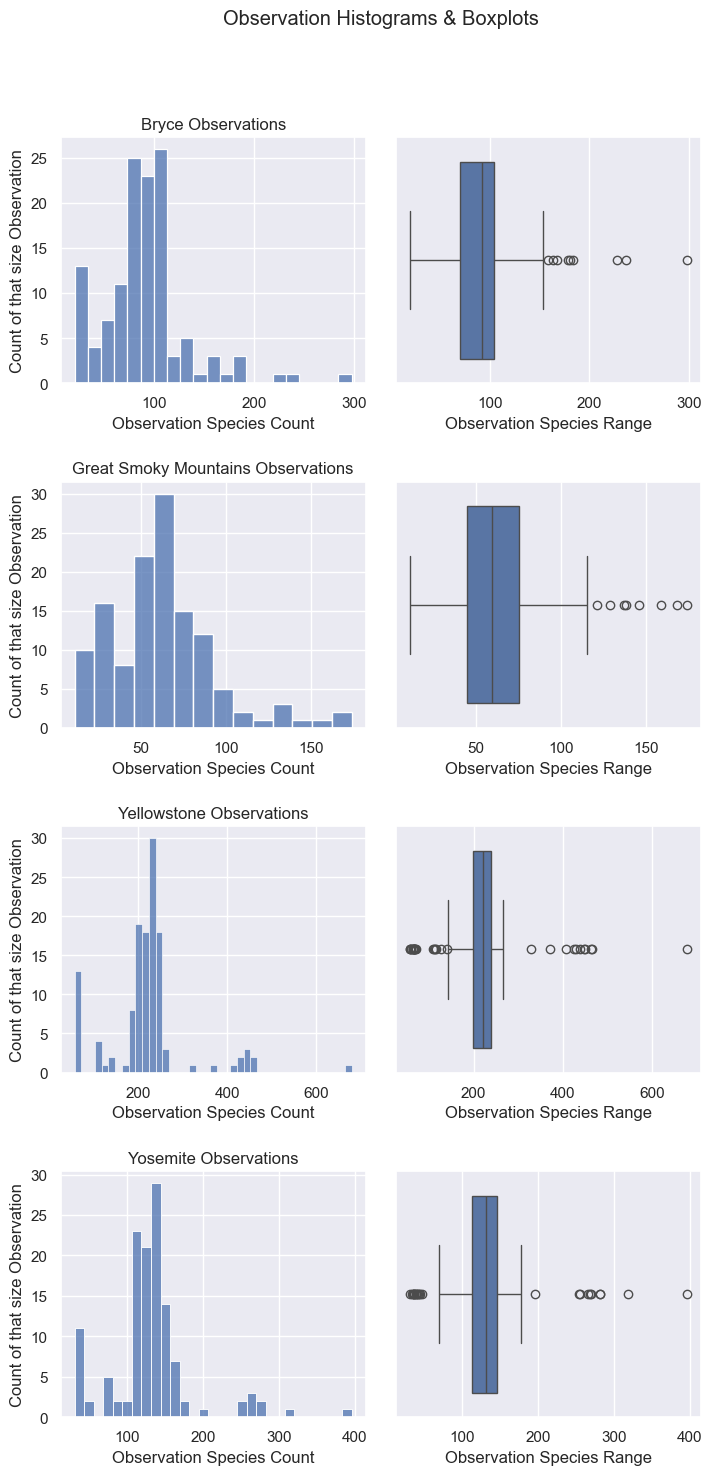

/var/folders/78/f1141hzn7hj2fl252vtz94f00000gn/T/ipykernel_1547/1027697656.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


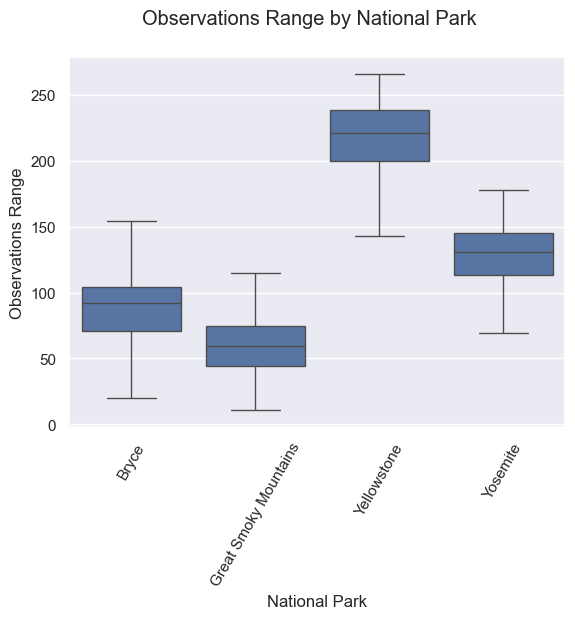

In [112]:
#Graph histograms of Observations for each park
biodiv_conservation_animals = biodiv_animals[biodiv_animals['protection_listing']==1]
parks = list(biodiv['park_name'].unique())
num = 1
fig =plt.figure('park_observation_normalcy', figsize=(8,16), )
fig.tight_layout()
fig.suptitle('Observation Histograms & Boxplots')
park_describe = {}
for park in parks:
    park_biodiv = biodiv_conservation_animals[biodiv_conservation_animals['park_name']==park]
    park_mean = park_biodiv['observations'].describe(include=all)
    park_describe[park]= park_mean
    plt.subplot(4,2,num)
    sns.histplot(park_biodiv['observations'])
    plt.title(park + ' Observations')
    plt.xlabel('Observation Species Count')
    plt.ylabel('Count of that size Observation')
    num +=1
    plt.subplot(4,2,num)
    sns.boxplot(x='observations', data=park_biodiv)
    plt.xlabel('Observation Species Range')
    num +=1
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.4)
plt.savefig('png_park_observation_normalcy.png')
plt.show()
plt.close('all')

fig2=plt.figure('park_relative_observations')
ax = plt.subplot(1,1,1)
sns.boxplot(data=biodiv_conservation_animals, x='park_name', y='observations', showfliers = False)
plt.suptitle('Observations Range by National Park')
plt.xlabel('National Park')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.ylabel('Observations Range')
plt.savefig('png_park_observations_range.png')
plt.show()
plt.close('all')
parks_describe_df = pd.DataFrame(park_describe)

ANOVA F and p value: 
              sum_sq    df     F  PR(>F)
park_name 1817091.9   3.0 169.0     0.0
Residual  1820856.6 508.0   NaN     NaN
Model Results Summary: 
                            OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     169.0
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           5.73e-76
Time:                        21:10:58   Log-Likelihood:                -2819.7
No. Observations:                 512   AIC:                             5647.
Df Residuals:                     508   BIC:                             5664.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         co

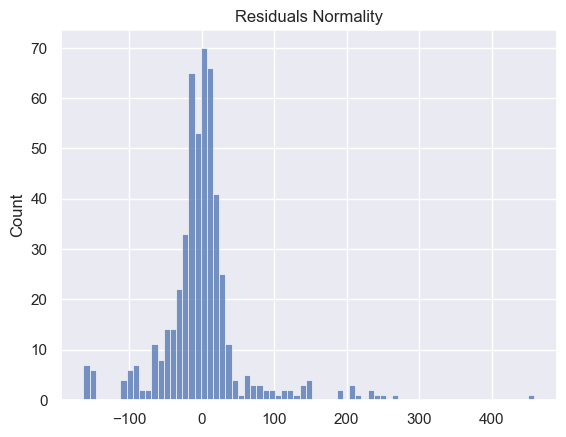

<Figure size 640x480 with 0 Axes>

In [113]:
#ANOVA using OLS- Ordinary Least Squares
model = sm.OLS.from_formula('observations~park_name', biodiv_conservation_animals)
results = model.fit()
anova_table = sm.stats.anova_lm(results, typ=2)
print(f"ANOVA F and p value: \n {anova_table}")
print(f"Model Results Summary: \n{results.summary()}")
residuals = biodiv_conservation_animals.observations-results.predict(biodiv_conservation_animals)
plt.figure()
sns.histplot(residuals)
plt.savefig('png_residules_park_obs_anova.png')
plt.title("Residuals Normality")
plt.show()
plt.clf()


                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                group2        meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------------------
                Bryce Great Smoky Mountains -28.3203 0.001  -47.6099  -9.0307   True
                Bryce           Yellowstone 129.4609   0.0  110.1713 148.7506   True
                Bryce              Yosemite  41.3438   0.0   22.0541  60.6334   True
Great Smoky Mountains           Yellowstone 157.7812   0.0  138.4916 177.0709   True
Great Smoky Mountains              Yosemite  69.6641   0.0   50.3744  88.9537   True
          Yellowstone              Yosemite -88.1172   0.0 -107.4068 -68.8276   True
------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

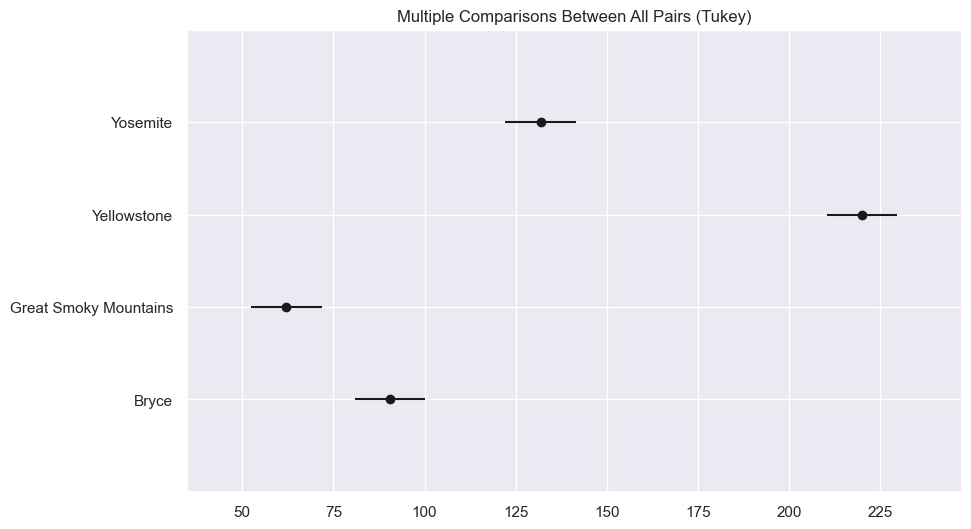

In [114]:
tukey_results = pairwise_tukeyhsd(endog=biodiv_conservation_animals['observations'], groups=biodiv_conservation_animals['park_name'], alpha=0.05)
# Print the results
print(tukey_results)
fig = plt.figure()
tukey_results.plot_simultaneous()
plt.savefig("png_tukeyhsd_results.png")
plt.show()
plt.close('all')

#### Is there an interaction between National Park and species category with respect to mean observations in animals with a conservation listing. 
**Method:**
    OLS - Using statmodels.api's OLS.from_formula create the ordinary least squares model, fit the model, and apply statsmodel.stats anova_lm. 

- Analysis:
    With regard to mean observations National park has an F of 173 with a p-value below the threshold for statistical significance. Species category also has a statistically significant but much weaker correlation with observation mean with an F o 5.6. However, there is no statistical support for an interaction between National Park and Species Category with regard to mean observations.
    
|Comparison Group | F | PR(>F) | 
| --- | --- | --- |
| park_name| 173.1951432 | 0.0000000
| category | 5.6413516 | 0.0001908
|C(park_name):C(category) | 0.5080420 | 0.91|
    
- Conclusion: Park and Category are both independently correlated to observations in this data set, but they do not interact. 

In [115]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)
model2 = sm.OLS.from_formula('observations~C(park_name)*C(category)', biodiv_conservation_animals)
results2 = model2.fit()
anova_table_2way = sm.stats.anova_lm(results2, typ=2)

print(anova_table_2way)

                                  sum_sq          df           F    PR(>F)
C(park_name)             1817091.9453125   3.0000000 173.1951432 0.0000000
C(category)                78915.6423715   4.0000000   5.6413516 0.0001908
C(park_name):C(category)   21320.6687351  12.0000000   0.5080420 0.9098909
Residual                 1720620.2982684 492.0000000         NaN       NaN


#### Conclusion:

The biodiversity dataset provided by Codecademy.com contained a few interesting relationships. Though the bulk of the data included observations of species without a conservation listing and of species of plants, there were still interesting findings around relationships between National Parks and observational means and between species categories and protection listing/conservation status. 


**Is species category correlated to protection listing or conservation status?**

The table below gives the Chi2 statistic, p-value, and Cramér's V  for eache subset of species category compared to protection listing and in the last line of the table, the conservation status. 

Species category across the dataset was weakly correlated with protection listing. While the high Chi2 statistic and very low p-value indicate robust statistical significance, the relatively low Cramér's V indicates a relatively weak relationship. 

Breaking the species categories into subsets between plants and animal categories, allowed for greater granularity to investigate if a particular subset had more influence on conservation status. Plant species category had no correlation with protection listing, but animal species showed a very weak, but statisically significant correlation.  The weak relationship between animal species and protection listing suggested that a more nuanced analysis might show a more robust influence, so covariance analysis was performed on the subset of protection listed animals, comparing their conservation status with species category.  

The Chi2 statistic and p-value indicated a statistically significant correlation between species category and conservation status for the subset of protected animal species.  In order to measure the strength of the relationship Cramér's V was applied to the model, revealing a moderate strength relationship between the variables. 

| Analysis Group | Chi2 | P-Value | Cramér's V |
| --- | --- | --- | --- |
| All Species - Protection Listing | 426.6 | 5.14 e-89 | 0.277 |
| Plant Species - Protection Listing | 0.19| 0.66 | n/a |
| Animal Species - Protection Listing |10.5| 0.03 | 0.10 |
| Protected Animal Species - Conservation Status | 40.91| 5.08 e-05 | 0.33 |


**Is National Park correlated with Observations**

The intial visualization show clear differences in the mean observations between national parks. To investigate these differences, the national parks observations were modeled using Ordinary Least Squares. The ANOVA for the ordinary least squares model of National Park and observations showed a statistically significant,  strong correlation to the mean observations across the dataset. Following up on the ANOVA, analysis with Tukey HSD was used to find the pairwise relationship of the means between each of the National Parks. All pairwise relationships were statistically significant. 

| F-Statistic | p-Value |
| --- | --- |
| 169 | 5.73e-76 |

| Park 1 |  Park 2 | meandiff|
| --- |--- | --- |
| Bryce | Great Smoky Mountains | -28.32 |
| Bryce | Yellowstone | 129.46 |
| Bryce | Yosemite | 41.34 |
| Great Smoky Mountains | Yellowstone | 157.78 |
| Great Smoky Mountains | Yosemite | 69.66 | 
| Yellowstone | Yosemite | -88.11 |

The National Park with the highest mean observations was Yellowstone, while the lowest was Great Smokey Mountains.  This is slightly different than the range of the total observations where the sum of all observations was lowest for Bryce National Park.



**Is there an interaction between National Park and Species Category with regard to observations?**

Since conservation status is based on the population of a species alive in the wild, observations and conservation status are proxy measures and have a positive linear relationship. This allows us to compare the subset of protection listed animal species and National park with regard to their relationships with observations and begin to see if there is a National Park at which we are more likely to find observations of protected species. If there is a statistically significant interaction between the variables then further investigation would be warranted to see if a particular conservation status is more common in a particular species category and specific parks. 


Interaction of species category and National Park were modeled vs observations for the subset of animals with protection listing. The strongest correlation was found between National Park and observations, with a strong, statistically significant difference of the means. Species Category was also correlated to observational means with a moderate, but still statistically significant relationship. However, the variables are independent as the interaction between National Park and Species Category did not have a statistically significant relationship as shown by the F statistic and p-value in the table below. 

|Comparison Group | F | p-value | 
| --- | --- | --- |
| park_name| 173.2 | 0.0000000
| category | 5.6 | 0.0001908
|C(park_name):C(category) | 0.51 | 0.91|

**Futher Questions**

Since the dataset showed a significant difference between the observational means at the National parks in future work it would be interesting to investigate a more complete dataset that includes datetime and location of observations to check for seasonal movements or observational windows that may impact the observational mean. It would also be interesting to investigate the relationship between park area and observations since Yellowstone is the largest of the parks and contains the highest observational means, while Bryce National Park, the smallest of the National parks with the smallest total sum fo observations, did not have the lowest observational mean. 